In [1]:
# %%time
# !tar -xf golos_100hours.tar

In [2]:
import torch
import torch.nn as nn
import torchaudio

In [3]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [4]:
import logging
import re
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm

In [5]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

In [6]:
class QuartzNet(nn.Module):
    def __init__(self, R_repeat, in_channels, out_channels):
        super(QuartzNet, self).__init__()

        block_channels = [256, 256, 256, 512, 512, 512]
        block_k = [33, 39, 51, 63, 75]

        self.C1 = nn.Sequential(
            nn.Conv1d(
                in_channels,
                in_channels,
                kernel_size=33,
                padding=16,
                stride=2,
                groups=in_channels,
                bias=False,
            ),
            nn.Conv1d(in_channels, 256, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        self.B = nn.ModuleList([])

        for i in range(5):
            num_in = block_channels[i]
            num_out = block_channels[i + 1]
            pad = block_k[i] // 2
            k = block_k[i]

            print(i, num_in, num_out, pad, k)

            self.B.append(JasperBlock(num_in, num_out, k, pad))

            for rep in range(R_repeat):
                self.B.append(JasperBlock(num_out, num_out, k, pad))

        self.C2 = nn.Sequential(
            nn.Conv1d(
                512, 512, kernel_size=87, padding=86, dilation=2, groups=512, bias=False
            ),
            nn.Conv1d(512, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        self.C3 = nn.Sequential(
            nn.Conv1d(512, 1024, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        self.C4 = nn.Conv1d(1024, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.C1(x)

        for block in self.B:
            x = block(x)

        x = self.C2(x)
        x = self.C3(x)
        x = self.C4(x)

        return x

In [7]:
class JasperBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k, padding):
        super(JasperBlock, self).__init__()

        self.blocks = nn.Sequential(
            ConvBlock(in_channels, out_channels, k, padding),
            ConvBlock(out_channels, out_channels, k, padding),
            ConvBlock(out_channels, out_channels, k, padding),
            ConvBlock(out_channels, out_channels, k, padding),
            ConvBlock(out_channels, out_channels, k, padding),
        )

        self.residual = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, kernel_size=(1,), stride=[1], bias=False
            ),
            nn.BatchNorm1d(out_channels, eps=0.001, momentum=0.1, affine=True),
        )

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        return self.dropout(self.relu(self.residual(x) + self.blocks(x)))

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k, padding):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv1d(
                in_channels,
                in_channels,
                kernel_size=k,
                stride=[1],
                padding=(padding,),
                dilation=[1],
                groups=in_channels,
                bias=False,
            ),
            nn.Conv1d(
                in_channels, out_channels, kernel_size=(1,), stride=(1,), bias=False
            ),
            nn.BatchNorm1d(out_channels, eps=0.001, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
# files = (
#     pd.read_json(path_or_buf="100hours.jsonl", lines=True)
#     .iloc[:75_000]
#     .reset_index(drop=True)
# )

In [10]:
# test_files = (
#     pd.read_json(path_or_buf="100hours.jsonl", lines=True)
#     .iloc[75_000:]
#     .reset_index(drop=True)
# )

In [11]:
files = (
    pd.read_json(path_or_buf="train_opus/manifest.jsonl", lines=True)
)
files = files[files['duration'] > 1].sample(400_000).reset_index(drop=True)

In [12]:
files.duration.sum() / 3600

444.93871824652786

In [13]:
test_crowd = pd.read_json(path_or_buf="test_opus/crowd/manifest.jsonl", lines=True)
test_crowd['audio_filepath'] = 'crowd/' + test_crowd['audio_filepath']

test_farfield = pd.read_json(path_or_buf="test_opus/farfield/manifest.jsonl", lines=True)
test_farfield['audio_filepath'] = 'farfield/' + test_farfield['audio_filepath']

In [14]:
test_files = (
    pd.concat(
        [
            test_crowd,
            test_farfield,
        ]
    )
    .reset_index(drop=True)
)
test_files = test_files[test_files['duration'] > 1].reset_index(drop=True)

In [15]:
chars = [
    " ",
    "а",
    "б",
    "в",
    "г",
    "д",
    "е",
    "ж",
    "з",
    "и",
    "й",
    "к",
    "л",
    "м",
    "н",
    "о",
    "п",
    "р",
    "с",
    "т",
    "у",
    "ф",
    "х",
    "ц",
    "ч",
    "ш",
    "щ",
    "ъ",
    "ы",
    "ь",
    "э",
    "ю",
    "я",
]
int_to_char = dict(enumerate(chars))
char_to_int = {v: k for k, v in int_to_char.items()}

In [16]:
class GolosDataset(Dataset):
    def __init__(self, mode: str, files, spec_aug=None):
        super(GolosDataset, self).__init__()

        self.mode = mode
        self.collection = files
        self.sr = 16_000
        self.spec_aug = spec_aug

    def __len__(self):
        return len(self.collection)

    def __getitem__(self, item):
        audio_path = self.collection["audio_filepath"][item]
        transcript = self.collection["text"][item]

        transcript_tensor = torch.tensor(
            [char_to_int[i] for i in transcript], dtype=torch.long
        )

        if self.mode == "train":
            waveform, sample_rate = torchaudio.load(
                "train_opus/" + audio_path, normalize=True
            )
        else:
            waveform, sample_rate = torchaudio.load(
                "test_opus/" + audio_path, normalize=True
            )
        waveform = torchaudio.transforms.Resample(sample_rate, self.sr)(waveform)
        
        if self.spec_aug is None:
            mel_spectrogram = torchaudio.transforms.MelSpectrogram(
                n_mels=64,
                sample_rate=self.sr,
                n_fft=400,
                power=2,
                f_min=0.0,
            )(waveform)
        else:
            # Convert to power spectrogram
            spectrogram = torchaudio.transforms.Spectrogram(
                n_fft=400,
                power=2,
            )(waveform)
            # Apply SpecAugment
            aug_spectrogram = self.spec_aug(spectrogram)
            # Convert to mel-scale
            mel_spectrogram = torchaudio.transforms.MelScale(
                n_mels=64,
                sample_rate=self.sr,
                f_min=0.0,
            )(aug_spectrogram)
        
        log_mel_spec = torch.log(torch.clamp(mel_spectrogram, min=1e-10))

        input_length = log_mel_spec.shape[-1]
        label_length = len(transcript_tensor)

        return {
            "melspec": log_mel_spec.squeeze(0),
            "text": transcript_tensor,
            "input_length": input_length,
            "label_length": label_length,
        }

In [17]:
spec_aug = torch.nn.Sequential(
    # torchaudio.transforms.TimeStretch(0.9, fixed_rate=True),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=20),
    torchaudio.transforms.TimeMasking(time_mask_param=5),
)

In [18]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
train_dataset = GolosDataset("train", files, spec_aug)
test_dataset = GolosDataset("test", test_files)

In [20]:
data = train_dataset[1]
log_mel_spec = data["melspec"]
transcript = data["text"]
input_length = data["input_length"]
label_length = data["label_length"]

In [21]:
data = test_dataset[1]
log_mel_spec = data["melspec"]
transcript = data["text"]
input_length = data["input_length"]
label_length = data["label_length"]

In [22]:
len(chars)

33

In [23]:
model = QuartzNet(
    R_repeat=0,
    in_channels=64,
    out_channels=len(chars) + 1,  # for blank token (ctc loss)
)

0 256 256 16 33
1 256 256 19 39
2 256 512 25 51
3 512 512 31 63
4 512 512 37 75


In [24]:
# model = torch.load('quartznet_5x5.model')

In [25]:
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,718,306 trainable parameters


In [26]:
def collate_fn(batch):
    melspecs = [row["melspec"] for row in batch]
    texts = [row["text"] for row in batch]
    input_lengths = [row["input_length"] for row in batch]
    label_lengths = [row["label_length"] for row in batch]

    specs = [torch.transpose(spec, 0, 1) for spec in melspecs]
    specs = pad_sequence(specs, batch_first=True)
    specs = torch.transpose(specs, 1, 2)

    labels = pad_sequence(texts, batch_first=True)
    return (
        specs,
        labels,
        torch.tensor(input_lengths),
        torch.tensor(label_lengths),
    )

In [27]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True,
)

In [28]:
# sum_stat = 0
# for i in tqdm(train_dataset):
#     sum_stat = i['melspec'].sum(1)

# mean = sum_stat / len(train_dataset)

# sum_stat = 0
# for i in tqdm(train_dataset):
#     sum_stat += ((i['melspec'] - mean.unsqueeze(1))**2).sum(1)

# std = (sum_stat / len(train_dataset)) ** (0.5)

In [29]:
for batch in train_loader:
    melspecs = batch[0]
    texts = batch[1]
    input_lengths = batch[2]
    label_lengths = batch[3]
    output = model(melspecs)
    output = F.log_softmax(output, dim=1)
    print("mel", melspecs.shape)
    print("texts", texts.shape)
    print(output.shape)
    break

mel torch.Size([32, 64, 479])
texts torch.Size([32, 64])
torch.Size([32, 34, 240])


In [30]:
melspecs.isinf().sum()

tensor(0)

In [31]:
texts[1]

tensor([18,  6, 17,  9,  1, 12,  0, 15, 19,  6, 12, 29,  0,  3,  1,  3,  9, 12,
        15, 14,  0, 18,  6,  8, 15, 14,  0, 25,  6, 18, 19, 29,  0, 24,  1, 18,
        19, 29,  0, 25,  6, 18, 19, 14,  1,  5, 23,  1, 19, 29,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

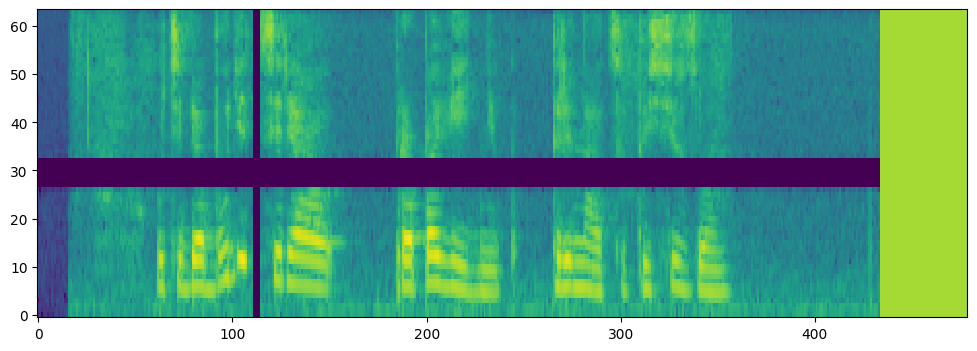

In [32]:
plt.figure(figsize=(12, 4))
plt.imshow(melspecs[20].numpy(), aspect="auto", origin="lower", interpolation="none")

In [33]:
# output.shape

In [34]:
# melspecs.shape

In [35]:
# melspecs[2]

In [36]:
# input_lengths

In [37]:
# criterion = nn.CTCLoss(blank=len(chars), zero_infinity=True)
# criterion(
#     output.permute(2, 0, 1),
#     texts,
#     torch.ceil(input_lengths.float() / 2).int(),
#     label_lengths,
# )

In [38]:
torch.cuda.is_available()

True

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(device)

model = model.to(device)

2024-04-05 22:11:48,698 - root - INFO - cuda


In [40]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler,
    device: str,
    clip: float = 3.0,
    train_history=None,
    valid_history=None,
):
    epoch_loss = 0
    history = []

    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        try:
            melspecs = batch[0].to(device)
            texts = batch[1].to(device)
            input_lengths = batch[2].to(device)
            label_lengths = batch[3].to(device)
    
            output = model(melspecs).permute(2, 0, 1)
            output = F.log_softmax(output, dim=2)
    
            loss = criterion(
                output,
                texts,
                torch.ceil(input_lengths.float() / 2).int(),
                label_lengths,
            )
        except Exception as e:
            print(e)
            continue
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # scheduler.step()

        history.append(loss.cpu().data.numpy())
        if ((i + 1) % 30 == 0) or (i == (len(train_loader) - 1)):
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

            clear_output(True)
            ax[0].plot(history, label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()

            plt.show()
        i += 1

    return epoch_loss / len(train_loader), loss

In [41]:
def validate(
    model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: str
):

    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            melspecs = batch[0].to(device)
            texts = batch[1].to(device)
            input_lengths = batch[2].to(device)
            label_lengths = batch[3].to(device)

            output = model(melspecs).permute(2, 0, 1)
            output = F.log_softmax(output, dim=2)
            loss = criterion(
                output,
                texts,
                torch.ceil(input_lengths.float() / 2).int(),
                label_lengths,
            )
            epoch_loss += loss.item()

    return epoch_loss / len(valid_loader)

In [42]:
def test(
    model: nn.Module, dataset: Dataset, ind: int
):
    model.eval()
    
    with torch.no_grad():
    
        melspecs = dataset[ind]["melspec"]
        texts = dataset[ind]["text"]
        input_lengths = dataset[ind]["input_length"]
        label_lengths = dataset[ind]["label_length"]

        output = model(melspecs.to('cuda').unsqueeze(0)).permute(2, 0, 1)
        output = F.log_softmax(output, dim=2)
        output = output.permute(1, 0, 2)
        output.shape

        ground_true = ''.join([int_to_char[i] for i in texts.cpu().numpy().tolist()])
        predicted = ''.join([int_to_char.get(i, '') for i in output.argmax(dim=2).cpu().numpy().tolist()[0]])

        print(f'ground_true: {ground_true}')
        print(f'predicted: {predicted}')

In [49]:
def fit(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    criterion,
    optimizer,
    scheduler,
    start_epoch: int,
    end_epoch: int,
    clip: float = 3.0,
):
    
    train_losses = []
    valid_losses = []

    best_valid_loss = 0.9

    for epoch in range(start_epoch, end_epoch):
        train_loss, last_batch_loss = train(
            model,
            train_loader,
            criterion,
            optimizer,
            scheduler,
            device,
            clip,
            train_losses,
            valid_losses,
        )
        valid_loss = validate(model, valid_loader, criterion, device)
        logging.info(
            f"Epoch: {epoch}, Training Loss: {train_loss}, Valid Loss: {valid_loss}"
        )
        
        test(model, test_dataset, 300)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        if valid_loss < best_valid_loss:
            torch.save(model, f"quartznet_5x5_{epoch}.model")
            best_valid_loss = valid_loss

        save_checkpoint(
            last_epoch=epoch,
            last_batch_idx=epoch * len(train_loader) - 1,
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            loss=last_batch_loss,
        )
        logging.info('checkpoint created')
        
    return train_losses, valid_losses

In [50]:
def save_checkpoint(
    last_epoch: int,
    last_batch_idx: int,
    model,
    optimizer,
    scheduler,
    loss,
    path: str = "quartznet",
    postfix: str = "last_667",
):

    if not os.path.exists(path):
        os.mkdir(path)

    torch.save({
        'last_epoch': last_epoch,
        'last_batch_idx': last_batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        }, os.path.join(path, f"model_{postfix}.checkpoint"))

In [51]:
def load_checkpoint(
    model,
    optimizer,
    scheduler,
    path: str = "quartznet",
    postfix: str = "last_667",
):
    checkpoint = torch.load(os.path.join(path, f"model_{postfix}.checkpoint"))
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    last_epoch = checkpoint['last_epoch']
    last_batch_idx = checkpoint['last_batch_idx']
    loss = checkpoint['loss']

    return (
        model,
        optimizer,
        scheduler,
        last_epoch,
        last_batch_idx,
    )

In [52]:
from_checkpoint = True

In [53]:
end_epoch = 10
criterion = nn.CTCLoss(blank=len(chars), zero_infinity=True)
if from_checkpoint:
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=end_epoch,
        div_factor=25.0,
        pct_start=0.3,
        last_epoch=-1,
    )
    model, optimizer, scheduler, last_epoch, last_batch_idx = load_checkpoint(
        model,
        optimizer,
        scheduler,
    )
    start_epoch = last_epoch + 1
    scheduler.last_epoch = last_batch_idx
else:
    start_epoch = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=end_epoch,
        div_factor=25.0,
        pct_start=0.3,
        last_epoch=-1,
    )

In [54]:
start_epoch

9

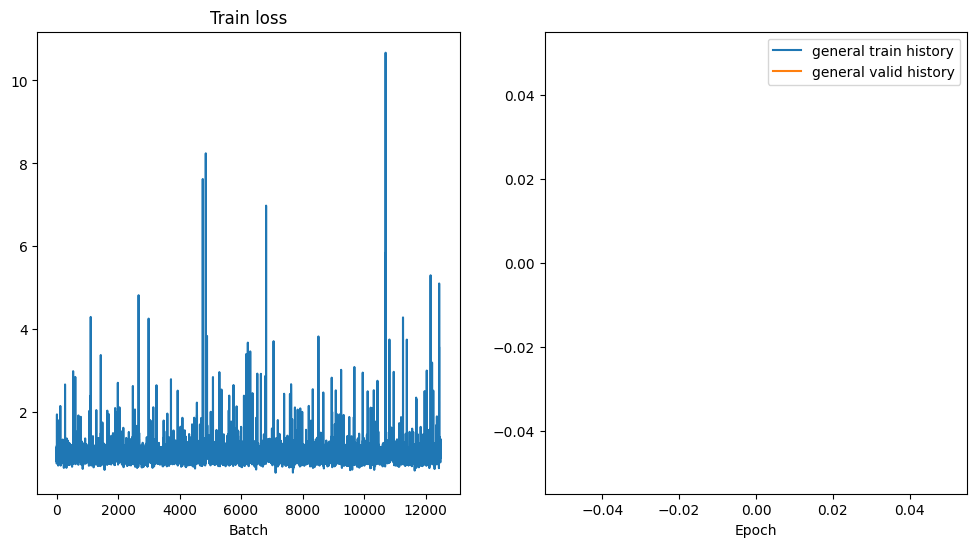

100%|████████████████████████████████████████████████████████████████████████████████| 372/372 [01:46<00:00,  3.51it/s]

2024-04-06 01:03:21,027 - root - INFO - Epoch: 9, Training Loss: 0.9845657639980316, Valid Loss: 0.8699753078561957


ground_true: можешь включить сорок девять дней
predicted: можжеешшьь  вкклюючиитьь ссергени
2024-04-06 01:03:21,298 - root - INFO - checkpoint created


In [55]:
train_losses, valid_losses = fit(
    model=model,
    train_loader=train_loader,
    valid_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    start_epoch=start_epoch,
    end_epoch=end_epoch,
)

In [56]:
model.eval()

QuartzNet(
  (C1): Sequential(
    (0): Conv1d(64, 64, kernel_size=(33,), stride=(2,), padding=(16,), groups=64, bias=False)
    (1): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
    (2): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
  )
  (B): ModuleList(
    (0): JasperBlock(
      (blocks): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1d(256, 256, kernel_size=(33,), stride=(1,), padding=(16,), groups=256, bias=False)
            (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
            (2): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (3): ReLU()
            (4): Dropout(p=0.2, inplace=False)
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1d(256, 256, kernel_size=(33,), stride=(1,), padding=(16,), groups=256, bias=False)

In [57]:
torch.save(model, "quartznet/quartznet_5x5_667.model")

In [53]:
checkpoint = torch.load(os.path.join("quartznet", f"model_last_667.checkpoint"))

In [54]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [69]:
ind = 3
melspecs = test_dataset[ind]["melspec"]
texts = test_dataset[ind]["text"]
input_lengths = test_dataset[ind]["input_length"]
label_lengths = test_dataset[ind]["label_length"]

In [59]:
ind = 30
melspecs = train_dataset[ind]["melspec"]
texts = train_dataset[ind]["text"]
input_lengths = train_dataset[ind]["input_length"]
label_lengths = train_dataset[ind]["label_length"]

In [60]:
output = model(melspecs.to(device).unsqueeze(0)).permute(2, 0, 1)
output = F.log_softmax(output, dim=2)
output = output.permute(1, 0, 2)
output.shape

torch.Size([1, 146, 34])

In [61]:
"".join([int_to_char[i] for i in texts.cpu().numpy().tolist()])

'марина федоровна'

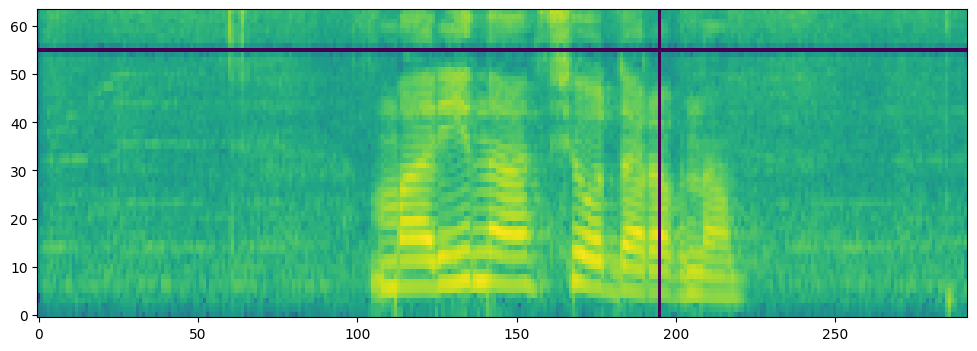

In [62]:
plt.figure(figsize=(12, 4))
plt.imshow(melspecs.numpy(), aspect="auto", origin="lower", interpolation="none")

In [63]:
"".join(
    [int_to_char.get(i, "$") for i in output.argmax(dim=2).cpu().numpy().tolist()[0]]
)

'$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ммаа$$$рр$и$$$нн$а$$$$ $$$с$$е$$$$$д$оо$рооовввннна$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'

In [64]:
"".join(
    [int_to_char.get(i, "") for i in output.argmax(dim=2).cpu().numpy().tolist()[0]]
)

'ммаарринна седоорооовввннна'

In [65]:
model.eval()
for ind in np.random.randint(0, len(test_dataset), size=10):
    melspecs = test_dataset[ind]["melspec"]
    texts = test_dataset[ind]["text"]
    input_lengths = test_dataset[ind]["input_length"]
    label_lengths = test_dataset[ind]["label_length"]

    output = model(melspecs.unsqueeze(0).to(device)).permute(2, 0, 1)
    output = F.log_softmax(output, dim=2)
    output = output.permute(1, 0, 2)

    original_text = "".join([int_to_char[i] for i in texts.cpu().numpy().tolist()])

    predicted_text = "".join(
        [int_to_char.get(i, "") for i in output.argmax(dim=2).cpu().numpy().tolist()[0]]
    )

    logging.info(f'{ind}: {original_text}\n{predicted_text}')

2024-04-06 01:04:39,348 - root - INFO - 6813: курс тысяч казахских тенге к английскому фунту на сегодня
ккурррсь  ттыыссяячччи  поззаххсскиххх   пеннге каннлийскомму  фундув  на ссеггодддння
2024-04-06 01:04:39,445 - root - INFO - 2947: у тебя в запасе есть спасти санту
у  ттееббяя вв  ззаппассее    есстттьь   пасстисаант
2024-04-06 01:04:39,496 - root - INFO - 2899: фэнтези
файктззии
2024-04-06 01:04:39,561 - root - INFO - 8494: киношка люди в черном три покажи
кииноошка  любивчоррнном трри  ппокажиии
2024-04-06 01:04:39,616 - root - INFO - 2685: покажи мне встречу апл манчестер против манчестер сити
пппокажи  ммнее всстрреччу  апплллл   ммааннчеесссттеерр  ппрооттиввв мманннччеесссттеерр сситии
2024-04-06 01:04:39,678 - root - INFO - 2099: музыка ютуб
ммозыкаа ютубб
2024-04-06 01:04:39,736 - root - INFO - 1518: джой запиши меня к терапевту на понедельник
ддджжоййй   зааппееше меення ктееррпетта на  понденик
2024-04-06 01:04:39,789 - root - INFO - 9437: севак ханагян на ютюбе
фивоокма

In [66]:
model.eval()
for ind in np.random.randint(0, len(test_dataset), size=10):
    melspecs = test_dataset[ind]["melspec"]
    texts = test_dataset[ind]["text"]
    input_lengths = test_dataset[ind]["input_length"]
    label_lengths = test_dataset[ind]["label_length"]

    output = model(melspecs.unsqueeze(0).to(device)).permute(2, 0, 1)
    output = F.log_softmax(output, dim=2)
    output = output.permute(1, 0, 2)

    original_text = "".join([int_to_char[i] for i in texts.cpu().numpy().tolist()])

    predicted_text = "".join(
        [int_to_char.get(i, "") for i in output.argmax(dim=2).cpu().numpy().tolist()[0]]
    )

    logging.info(f'{ind}: {original_text}\n{predicted_text}')

2024-04-06 01:06:46,237 - root - INFO - 1074: где находится девять акров
ггдде  нахходдииттссяя  деввячкка
2024-04-06 01:06:46,290 - root - INFO - 4670: включи биг бэнг
ввкклллюччии  бегданк
2024-04-06 01:06:46,343 - root - INFO - 3550: хочу на телевизоре канал амедиа один
чуу ннаа   ттеелллеевввииззоорррее  ккканнааллл  амеегииодиинн
2024-04-06 01:06:46,391 - root - INFO - 9637: вилюйске
ввилевойсске
2024-04-06 01:06:46,424 - root - INFO - 9192: поиск любимые команды манчестер юнайтед матчи
ожжа крлюббиемный  ккооммаада   мманннччеееттерр    юююннайййттеедд   маати
2024-04-06 01:06:46,477 - root - INFO - 2019: джой долгота измайловский парк
дджжжооййй  далнаа  изнаасипа
2024-04-06 01:06:46,537 - root - INFO - 4549: давайте втроем
довааййки  тровеем
2024-04-06 01:06:46,586 - root - INFO - 607: найти лучшие фильмы жанра драма
ннайййттии    ллллуучччшшшииее  фффиилльььммыыы    жжаанннрррааа   дррааммаа
2024-04-06 01:06:46,632 - root - INFO - 11494: сбер следующая
ссбберрр  ссеб
2024-04-0